Environmental Setup and Data Loading

In [1]:
#importing required libraries
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
import pandas as pd
%matplotlib inline 

In [2]:
# reading dataset
data = pd.read_csv('JOY DATASET 2.csv')

In [3]:
# show the 1st 5 lines of dataset
data.head()

,Age,Gender,family_history,work_interfere,mental_health_consequence,phys_health_consequence,obs_consequence,treatment
0,37,1,0,2,0.0,0.0,0,1
1,44,0,0,1,0.5,0.0,0,0
2,32,0,0,1,0.0,0.0,0,0
3,31,0,1,2,1.0,1.0,1,1
4,31,0,0,0,0.0,0.0,0,0


In [4]:
#checking the columns
data.columns

Index(['Age', 'Gender', 'family_history', 'work_interfere',
       'mental_health_consequence', 'phys_health_consequence',
       'obs_consequence', 'treatment'],
      dtype='object')

Preprocessing

In [5]:
#inspecting sample distribution per class using 'attack_status' where 1 means DDOS and 0 means Normal 
data['treatment'].value_counts()

1    1274
0    1244
Name: treatment, dtype: int64

In [6]:
#data['LnK'].value_counts()

This shows that the data is grossly imbalance

In [7]:
#defining input
input = data[['Age', 'Gender', 'family_history', 'work_interfere']]

In [8]:
#defining labels
label = data['treatment']

In [9]:
#spliting dataset into train and evaluation set at 80:20 ratio
train, val, train_label, val_label = train_test_split(input, label, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [10]:
print('The length of train set is: ', len(train))
print('The length of validation set is: ', len(val))

The length of train set is:  2014
The length of validation set is:  504


In [11]:
#inspecting train set
train.head()

,Age,Gender,family_history,work_interfere
1313,28,0,0,0
2151,29,0,1,0
1159,51,0,0,0
289,26,1,1,1
1186,56,1,0,1


In [12]:
val.head()

,Age,Gender,family_history,work_interfere
2196,33,0,1,0
410,33,0,1,2
1389,33,0,1,1
888,26,0,0,0
1772,39,0,0,0


In [13]:
print('train shape is', train.shape)
print('validation shape is', val.shape)


train shape is (2014, 4)
validation shape is (504, 4)


In [14]:
train = train.values
val = val.values

In [15]:
train = np.reshape(train, ((len(train), 4, 1, 1)))
val = np.reshape(val, (len(val), 4, 1, 1))

Modeling

In [16]:
cnnmodel = tf.keras.Sequential([
    tf.keras.layers.Conv2D(256, kernel_size=(1, 1),
                 activation='relu',
                 input_shape= [4, 1, 1]),
    tf.keras.layers.MaxPooling2D(pool_size=(1, 1)),        
    tf.keras.layers.Conv2D(64, (1, 1), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(1, 1)),
    tf.keras.layers.Conv2D(32, (1, 1), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(1, 1)),
    tf.keras.layers.Conv2D(32, (1, 1), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(1, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [17]:
cnnmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 4, 1, 256)         512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 1, 256)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 1, 64)          16448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 1, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 1, 32)          2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 1, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 1, 32)          1

In [18]:
checkpoint_filepath = '/content/drive/MyDrive/jet data/models/cnn'

In [19]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [20]:
cnnmodel.compile(loss='binary_crossentropy',
              optimizer= 'adam',
              metrics=[['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()]])

In [21]:
batch_size = 32

In [22]:
train = np.asarray(train).astype(np.float32)
val = np.asarray(val).astype(np.float32)
history = cnnmodel.fit(train, train_label, batch_size = batch_size, epochs = 100, verbose = 0,
                   steps_per_epoch = len(train) // batch_size,
                   validation_steps = len(val) // batch_size, 
                   validation_data = (val, val_label),
                   callbacks = [model_checkpoint_callback])

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/jet data/models\cnn\assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/jet data/models\cnn\assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/jet data/models\cnn\assets


In [23]:
#ypred = cnnmodel.predict(val)
#print(ypred)

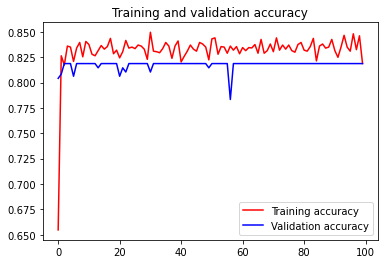

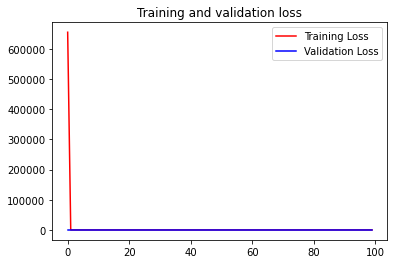

In [24]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))


plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Model Evaluation on validation set

In [25]:
#cnnmodel = tf.keras.models.load_model('/content/drive/MyDrive/jet data/models/cnn')

In [26]:
#training metrics in order:
#loss, accuracy, precision, recall, RMSE
print('The Training metrics are:')
cnnmodel.evaluate(train, train_label)

The Training metrics are:
63/63 [==============================] - 0s 3ms/step - loss: 0.3829 - accuracy: 0.8361 - precision: 0.7780 - recall: 0.9515 - root_mean_squared_error: 0.3451 - mean_squared_error: 0.1191 - mean_absolute_error: 0.2487


[0.38287243247032166,
 0.8361469507217407,
 0.7779539823532104,
 0.9515033960342407,
 0.34511473774909973,
 0.11910419166088104,
 0.24869735538959503]

In [27]:
#validation metrics in order:
#loss, accuracy, precision, recall, RMSE
print('The validation metrics are:')
cnnmodel.evaluate(val, val_label)

The validation metrics are:
16/16 [==============================] - 0s 2ms/step - loss: 0.4324 - accuracy: 0.8175 - precision: 0.7492 - recall: 0.9342 - root_mean_squared_error: 0.3685 - mean_squared_error: 0.1358 - mean_absolute_error: 0.2621


[0.43237659335136414,
 0.817460298538208,
 0.7491748929023743,
 0.9341563582420349,
 0.3684600591659546,
 0.13576281070709229,
 0.26213300228118896]

In [28]:
#obtaining confusion matrics for validation set
prediction = cnnmodel.predict(val)
print(prediction)

cm = tf.math.confusion_matrix(val_label, prediction, num_classes=2)
#defining function for confusion matrix display
import seaborn as sns
def show_confusion_matrix(cm, labels):
  print('printing confusion matrix in diagram mode: ')
  plt.figure(figsize=(4, 2))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()

[[0.11015496]
 [0.835382  ]
 [0.7948005 ]
 [0.02639216]
 [0.08228016]
 [0.1092822 ]
 [0.5567871 ]
 [0.8252381 ]
 [0.8318594 ]
 [0.07142684]
 [0.02784523]
 [0.7703162 ]
 [0.02639216]
 [0.699907  ]
 [0.794595  ]
 [0.79398775]
 [0.79645765]
 [0.63893217]
 [0.03748247]
 [0.03748247]
 [0.8540578 ]
 [0.11586025]
 [0.79099256]
 [0.03501496]
 [0.88097584]
 [0.67954195]
 [0.03501496]
 [0.9579666 ]
 [0.03501496]
 [0.8245363 ]
 [0.79645765]
 [0.63893217]
 [0.02784523]
 [0.8599944 ]
 [0.7991258 ]
 [0.84707856]
 [0.5114091 ]
 [0.7942456 ]
 [0.08228016]
 [0.79662913]
 [0.18185139]
 [0.8440873 ]
 [0.10554367]
 [0.8913259 ]
 [0.02087581]
 [0.15230957]
 [0.804919  ]
 [0.9030315 ]
 [0.58610755]
 [0.5273542 ]
 [0.8038063 ]
 [0.5456488 ]
 [0.02784523]
 [0.8440873 ]
 [0.05127826]
 [0.8647799 ]
 [0.5795519 ]
 [0.8608527 ]
 [0.11586025]
 [0.10318172]
 [0.02639216]
 [0.7991258 ]
 [0.02784523]
 [0.1608657 ]
 [0.02941877]
 [0.835382  ]
 [0.804919  ]
 [0.1064752 ]
 [0.1092822 ]
 [0.79398775]
 [0.11107355]
 [0.86

printing confusion matrix in diagram mode: 


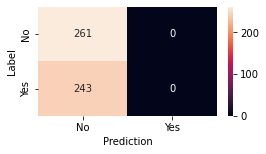

In [29]:
#subsequently, arrange in alphabetical order
labels = ['No', 'Yes']     
#confusion matrix display
show_confusion_matrix(cm, labels)

In [30]:
cnn_error = np.subtract(val, prediction)
df = pd.DataFrame(list(zip(val_label, prediction, cnn_error)), 
    columns=['Actual Value', 'CNN Prediction', 'CNN Error'])
#df.to_excel("result for cnn 80_20.xlsx")
df

,Actual Value,CNN Prediction,CNN Error
0,1,[0.11015496],"[[[32.889847], [32.16462], [32.2052], [32.9736..."
1,1,[0.835382],"[[[32.889847], [32.16462], [32.2052], [32.9736..."
2,1,[0.7948005],"[[[32.889847], [32.16462], [32.2052], [32.9736..."
3,0,[0.026392162],"[[[25.889845], [25.164618], [25.2052], [25.973..."
4,0,[0.08228016],"[[[38.889847], [38.16462], [38.2052], [38.9736..."
...,...,...,...
499,0,[0.022170156],"[[[22.889845], [22.164618], [22.2052], [22.973..."
500,0,[0.602818],"[[[33.889847], [33.16462], [33.2052], [33.9736..."
501,0,[0.041020423],"[[[32.889847], [32.16462], [32.2052], [32.9736..."
502,1,[0.8994422],"[[[44.889847], [44.16462], [44.2052], [44.9736..."


In [31]:
cnnmodel.save("C:/Users/NCC/Documents/MentalHealth/model/dumped.keras")

In [33]:
from tensorflow import keras
keras.models.load_model("C:/Users/NCC/Documents/MentalHealth/model/dumped.keras")